# Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.

One problem with PCA is that it's inherently **linear** -- it finds orthogonal components in the original data. Sometimes this assumption is a hindrance when doing dimensionality reduction

Imagine a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions. We can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings.

If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.

Manifold learning algorithms seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

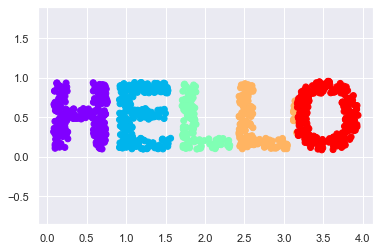

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

WORD = 'HELLO'

def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, WORD, va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [26]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

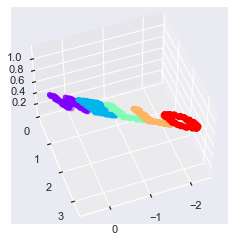

In [27]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

Fitting MDS to reduce this to two dimensions gets a rotated version of the data:

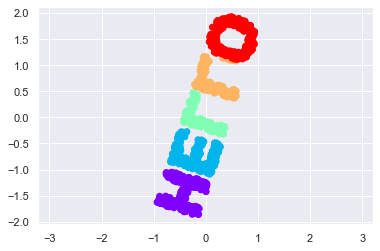

In [28]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

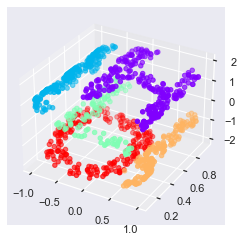

In [29]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

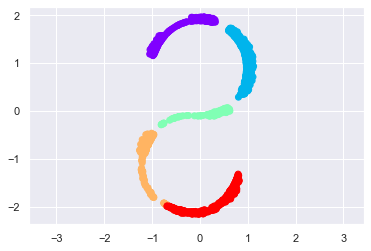

In [30]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?

LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

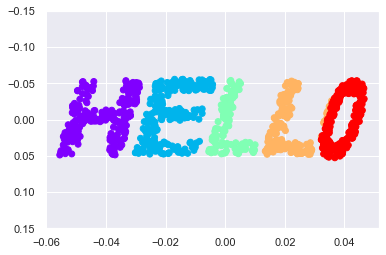

In [33]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

# UMAP

Uniform Manifold Approximations (UMAP) is an algorithm that approximates the manifold as a locally-connected graph and maintains the overall [topology](https://en.wikipedia.org/wiki/Topology) (disconnected parts, holes, etc.) in the original data.

UMAP is all the rage among data science practicioners these days.

This is great to visualize complex data, as it naturally learns clusters with relative positioning. It also scales well to larger datasets compared to other options.

/Users/mranger/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


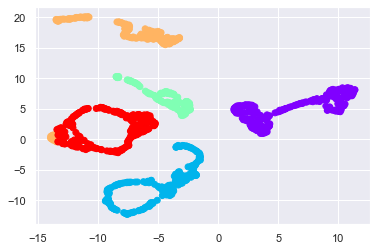

In [49]:
# pip install umap-learn
import umap

model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.4,
    metric='euclidean',
)
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

# T-SNE

T-Stochastic Neighbor embeddings (T-SNE) is another algorithm often used to visualize extremely high-dimensional data. It creates good visualizations though can be quite slow.

[Here](https://distill.pub/2016/misread-tsne/) is a great guide on using T-SNE effectively.

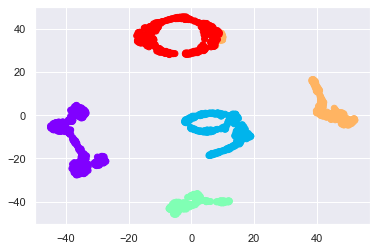

In [51]:
from sklearn import manifold

model = manifold.TSNE(n_components=2, perplexity=30.0)
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

## Some Thoughts on Manifold Methods

Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

- In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

- In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

- In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.


With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

## Example: Visualizing Structure in Digits

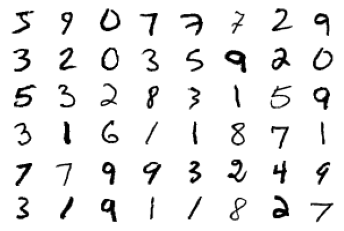

In [62]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, return_X_y=False, as_frame=False)
mnist.target = mnist.target.astype(int)
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

This gives us an idea of the variety of handwriting styles in the dataset.

Let's compute a manifold learning projection across the data.
For speed here, we'll only use 1/30 of the data, which is about ~2000 points
(because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

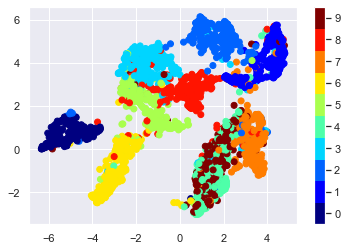

In [63]:
# use only 1/30 of the data
data = mnist.data[::30]
target = mnist.target[::30]

model = umap.UMAP(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded.
We can gain more insight by looking at just a single number at a time:

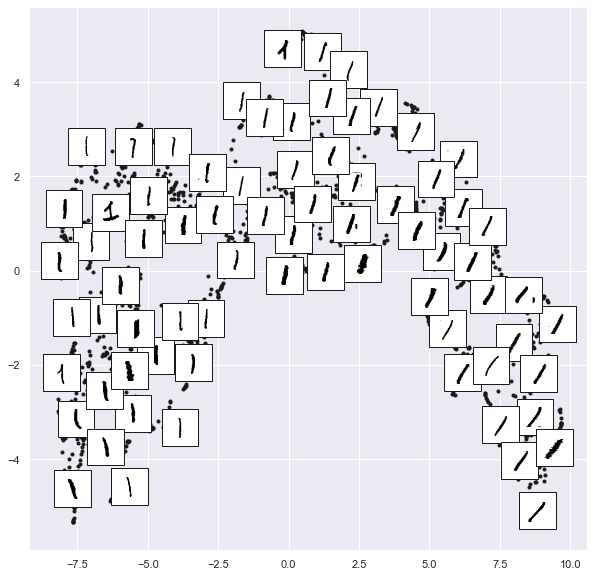

In [67]:
from sklearn.manifold import Isomap

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')